# Implement Hessian Loss Landscapes

Ashley S. Dale

Notebook loads a pretrained ALIGNN model, and calculates the loss landscape using Hessian directions


- Relevant paper: [*Visualizing high-dimensional loss landscapes with Hessian directions* by Bottcher and Wheeler](https://iopscience.iop.org/article/10.1088/1742-5468/ad13fc/meta)

---
Notebook Outline:

0. Select and load trained model and data

0. Generate a set of predictions for the data

0. Select a subset of well predicted instances to be "In Distribution" (ID) based on the z-score of the prediction error, where low z-score represents well predicted and therefore in-distribution

0. Select a subset of poorly predicted instances to be "Out of Distribution" (OOD) based on the z-score of the prediction error, where a high z-score represents poorly predicted and therefore out-of-distribution

0. Load Hessian eigenvectors as two new models. These models will define the coordinate axes of the loss landscape

0. Calculate the loss landscape using the original model as the origin, and the models generated from the eigenvectors of the Hessian as the two directions in which the original model is perturbed. Repeat this twice for the ID and OOD datasets.


In [1]:
# For the hessian calculation, these additional packages should be installed
# !pip install torchdiffeq

In [2]:
import copy
import torch
import glob
import json

import numpy as np
from tqdm import tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

import ipywidgets as widgets
from torchinfo import summary
from pymatgen.core.periodic_table import Element
from collections import OrderedDict

import alignn
from alignn.pretrained import *
from jarvis.db.figshare import data
from jarvis.db.figshare import data
from jarvis.db.jsonutils import loadjson

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

from src.utils import *

In [3]:
if torch. cuda. is_available():
    print("Using GPU ...")
    device = 'cuda'
else:
    device = 'cpu'

# Load Model

In [4]:
list_of_pretrained_models = list(get_all_models().keys())

-> Select the `jv_formation_energy_peratom_alignn` model for the demo

In [5]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list_of_pretrained_models,
    value=list_of_pretrained_models[0],
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [6]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [7]:
model = get_figshare_model(model_name)
model.to(device)
_ = model.eval()

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path c:\Users\hanyu\anaconda3_2\envs\losslandscapeEnv\lib\site-packages\alignn\jv_formation_energy_peratom_alignn.zip
Config c:\EH\UT\ML research\loss_landscapes_demo\jv_formation_energy_peratom_alignn\config.json


c:\Users\hanyu\anaconda3_2\envs\losslandscapeEnv\lib\site-packages\alignn\pretrained.py:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f

In [8]:
model_wt_dict = OrderedDict([i for i in model.named_parameters()])

In [9]:
summary(model)

Layer (type:depth-idx)                   Param #
ALIGNN                                   --
├─MLPLayer: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  23,808
│    │    └─BatchNorm1d: 3-2             512
│    │    └─SiLU: 3-3                    --
├─Sequential: 1-2                        --
│    └─RBFExpansion: 2-2                 --
│    └─MLPLayer: 2-3                     --
│    │    └─Sequential: 3-4              5,312
│    └─MLPLayer: 2-4                     --
│    │    └─Sequential: 3-5              17,152
├─Sequential: 1-3                        --
│    └─RBFExpansion: 2-5                 --
│    └─MLPLayer: 2-6                     --
│    │    └─Sequential: 3-6              2,752
│    └─MLPLayer: 2-7                     --
│    │    └─Sequential: 3-7              17,152
├─ModuleList: 1-4                        --
│    └─ALIGNNConv: 2-8                   --
│    │    └─EdgeGatedGraphConv: 3-8      329,984
│  

# Load Data

In [10]:
# target = 'optb88vdw_bandgap'
target = 'formation_energy_peratom'
n_samples = 200
element_to_omit_from_training_data = 'Fe'

In [11]:
d = data("dft_3d")
d = d[:n_samples]
dataset = DataFrame(copy.deepcopy(d))
atoms_df = DataFrame(list(DataFrame(d)['atoms']))
dataset = pd.concat([dataset, atoms_df], axis=1)
train_idx, test_idx = get_split(dataset, 'elements', element_to_omit_from_training_data)
print('num train samples: '+ str(len(train_idx)))
print('num test samples: '+ str(len(test_idx)))

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
num train samples: 186
num test samples: 14


In [12]:
train_data = [d[idx] for idx in train_idx.to_list()]
train_dataloader = get_data_loader(train_data, target, workers=0)

data range 2.71694 -3.53591
Converting to graphs!


100%|██████████| 186/186 [00:01<00:00, 139.22it/s]


df                                                  atoms     prop  jid
0    {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762    0
1    {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596    1
2    {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847    2
3    {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140    3
4    {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026    4
..                                                 ...      ...  ...
181  {'lattice_mat': [[3.5901111032581614, 0.0, 0.0... -0.39393  181
182  {'lattice_mat': [[3.8231338005011324, 0.0, 0.0... -0.19644  182
183  {'lattice_mat': [[5.343771579767017, 3.1726511... -2.63322  183
184  {'lattice_mat': [[2.790143252692178, -2.680152... -1.55369  184
185  {'lattice_mat': [[2.851156779425013, 0.0, -0.0... -2.49145  185

[186 rows x 3 columns]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available

100%|██████████| 186/186 [00:00<00:00, 2204.86it/s]


# Predicting on Test and Train Data

In [13]:
model_train_predictions = []
original_train_targets = []
for s in tqdm(train_dataloader):
    original_train_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_train_predictions.append(y_pred)

100%|██████████| 186/186 [00:16<00:00, 11.08it/s]


In [14]:
test_data = [d[idx] for idx in test_idx.to_list()]
test_dataloader = get_data_loader(test_data, target, workers=0)

model_test_predictions = []
original_test_targets = []
for s in tqdm(test_dataloader):
    original_test_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_test_predictions.append(y_pred)


data range 0.12011 -2.4143
Converting to graphs!


100%|██████████| 14/14 [00:00<00:00, 93.13it/s]

df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   1
2   {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3   {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   3
4   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   4
5   {'lattice_mat': [[2.80754625599962, 0.0, 0.0],... -2.41430   5
6   {'lattice_mat': [[2.719421627743509, 4.2176232... -1.99266   6
7   {'lattice_mat': [[4.857428829340624, 0.0, 0.0]... -2.22845   7
8   {'lattice_mat': [[1.413929176152854, -2.448997... -2.23094   8
9   {'lattice_mat': [[6.082481136762242, -0.039688...  0.12011   9
10  {'lattice_mat': [[4.935947268149975, 0.0075616... -0.21301  10
11  {'lattice_mat': [[4.293802725718504, 0.0, 0.0]... -1.39242  11
12  {'lattice_mat': [[4.110215016104089, 0.0, 0.0]... -0.04638  12
13  {'lattice_mat': [[6.93041047578813, 0.11598035... -1.97

building line graphs


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


## Subselect Train Data Samples: Most ID (Minimum Error)

In [15]:
train_df = pd.DataFrame(train_data)
train_df['pred_val'] = model_train_predictions
train_df['err'] = (train_df[target] - train_df['pred_val'])
train_df['abs_err'] = np.abs(train_df[target] - train_df['pred_val'])
train_df['z_score_err'] = (train_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [16]:
train_df

,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,pred_val,err,abs_err,z_score_err
0,JVASP-90856,129,P4/nmm,TiCuSiAs,-0.42762,OptB88vdW,0.000,"{'lattice_mat': [[3.566933224304235, 0.0, -0.0...",na,0.0,...,na,na,na,na,mp-1080455,-As-Cu-Si-Ti,-0.429359,0.001739,0.001739,-0.240511
1,JVASP-86097,221,Pm-3m,DyB6,-0.41596,OptB88vdW,0.000,"{'lattice_mat': [[4.089078911208881, 0.0, 0.0]...",na,0.0,...,na,na,na,na,mp-568319,-B-Dy,-0.417615,0.001655,0.001655,-0.243626
2,JVASP-64906,119,I-4m2,Be2OsRu,0.04847,OptB88vdW,0.000,"{'lattice_mat': [[-1.833590720595598, 1.833590...",na,0.0,...,na,na,na,na,auid-3eaf68dd483bf4f4,-Be-Os-Ru,0.046013,0.002457,0.002457,-0.213745
3,JVASP-98225,14,P2_1/c,KBi,-0.44140,OptB88vdW,0.472,"{'lattice_mat': [[7.2963518353359165, 0.0, 0.0...",na,0.0,...,na,na,na,na,mp-31104,-Bi-K,-0.444024,0.002624,0.002624,-0.207543
4,JVASP-10,164,P-3m1,VSe2,-0.71026,OptB88vdW,0.000,"{'lattice_mat': [[1.6777483798834445, -2.90594...",na,0.0,...,48.79,33.05,0.0,na,mp-694,-Se-V,-0.713197,0.002937,0.002937,-0.195889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,JVASP-86845,6,Pm,NaLi5N2,-0.39393,OptB88vdW,0.683,"{'lattice_mat': [[3.5901111032581614, 0.0, 0.0...",na,0.0,...,na,na,na,na,mp-569525,-Li-N-Na,-0.393834,-0.000096,0.000096,-0.301687
182,JVASP-97500,62,Pnma,CoIN2O2,-0.19644,OptB88vdW,1.275,"{'lattice_mat': [[3.8231338005011324, 0.0, 0.0...",na,0.0,...,na,na,na,na,mp-617167,-Co-I-N-O,-0.195089,-0.001351,0.001351,-0.254941
183,JVASP-52477,15,C2/c,Na2TiO3,-2.63322,OptB88vdW,3.235,"{'lattice_mat': [[5.343771579767017, 3.1726511...",0.46,0.0,...,na,na,3.732,na,mp-752423,-Na-O-Ti,-2.621071,-0.012149,0.012149,0.147263
184,JVASP-15431,71,Immm,Li2CuO2,-1.55369,OptB88vdW,0.000,"{'lattice_mat': [[2.790143252692178, -2.680152...",18.01,0.936,...,98.96,49.29,0.563,na,mp-4711,-Cu-Li-O,-1.554141,0.000451,0.000451,-0.288463


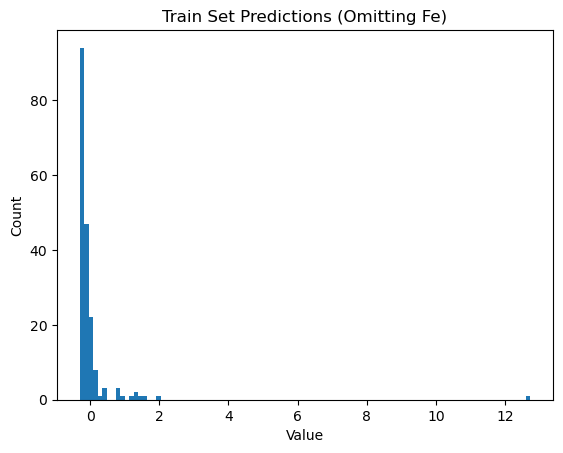

In [17]:
ax = plt.hist(train_df['z_score_err'].values, bins=100)
plt.title('Train Set Predictions (Omitting '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [18]:
train_subset_df = train_df.nsmallest(3, 'z_score_err')
train_subset_df_idx = train_subset_df.index.values.tolist()
train_subset_list = [train_data[i] for i in train_subset_df_idx]
train_subset_dataloader = get_data_loader(train_subset_list, target, workers=4)

data range -0.39393 -3.08933
Converting to graphs!


100%|██████████| 3/3 [00:00<00:00, 91.45it/s]


df                                                atoms     prop jid
0  {'lattice_mat': [[4.328319117003372, 1.032103e... -1.67055   0
1  {'lattice_mat': [[4.9619896140897275, -8.59441... -3.08933   1
2  {'lattice_mat': [[3.5901111032581614, 0.0, 0.0... -0.39393   2
building line graphs


100%|██████████| 3/3 [00:00<?, ?it/s]


In [19]:
subset_train_x = []
subset_train_y = []

for i in train_subset_dataloader:
    subset_train_x.append((i[0], i[1]))
    subset_train_y.append(i[2])

In [20]:
test_df = pd.DataFrame(test_data)
test_df['pred_val'] = model_test_predictions
test_df['err'] = (test_df[target] - test_df['pred_val'])
test_df['abs_err'] = np.abs(test_df[target] - test_df['pred_val'])
test_df['z_score_err'] = (test_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

## Subselect Test Samples - Most OOD (Maximum Error)

In [21]:
test_subset_df = test_df.nlargest(3, 'z_score_err')
test_subset_df_idx = test_subset_df.index.values.tolist()
test_subset_list = [test_data[i] for i in test_subset_df_idx]
test_subset_dataloader = get_data_loader(test_subset_list, target, workers=4)

data range 0.07844 -2.07159
Converting to graphs!


100%|██████████| 3/3 [00:00<00:00, 101.04it/s]


df                                                atoms     prop jid
0  {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1  {'lattice_mat': [[4.110215016104089, 0.0, 0.0]... -0.04638   1
2  {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   2
building line graphs


100%|██████████| 3/3 [00:00<?, ?it/s]


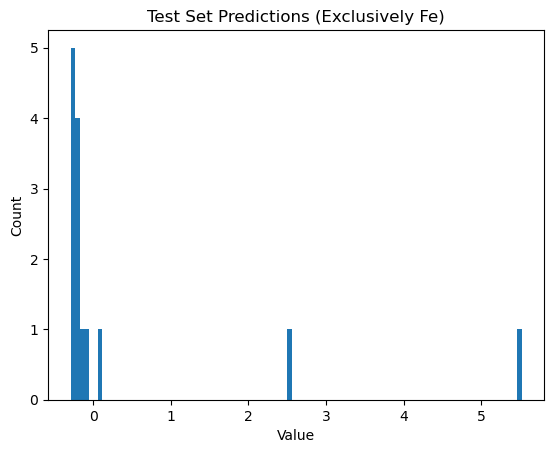

In [22]:
ax = plt.hist(test_df['z_score_err'].values, bins=100,)
plt.title('Test Set Predictions (Exclusively '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

# Getting the Hessian Eigenvectors

In [23]:
from src import botcher_hessian as hess
from src import botcher_utilities as util

The following functions are copy-pasted from Botcher implementation.  I put them here so that I could debug more easily.

In [24]:
def npvec_to_tensorlist(vec, params):
    """ Convert a numpy vector to a list of tensor with the same dimensions as params

        Args:
            vec: a 1D numpy vector
            params: a list of parameters from net

        Returns:
            rval: a list of tensors with the same shape as params
    """
    loc = 0
    rval = []
    for p in params:
        numel = p.data.numel()
        rval.append(torch.from_numpy(vec[loc:loc+numel]).view(p.data.shape).float())
        loc += numel
    assert loc == vec.size, 'The vector has more elements than the net has parameters'
    return rval


def gradtensor_to_npvec(net, all_params=True):
    """ Extract gradients from net, and return a concatenated numpy vector.

        Args:
            net: trained model
            all_params: If all_params, then gradients w.r.t. BN parameters and bias
            values are also included. Otherwise only gradients with dim > 1 are considered.

        Returns:
            a concatenated numpy vector containing all gradients
    """
    filter = lambda p: all_params or len(p.data.size()) > 1
    return np.concatenate([p.grad.data.cpu().numpy().ravel() for p in net.parameters() if filter(p)])


def eval_hess_vec_prod(vec, params, net, loss_func, inputs_dataloader, outputs, use_cuda=False):
    from torch.autograd import Variable
    """
    Evaluate product of the Hessian of the loss function with a direction vector "vec".
    The product result is saved in the grad of net.

    Args:
        vec: a list of tensor with the same dimensions as "params".
        params: the parameter list of the net (ignoring biases and BN parameters).
        net: model with trained parameters.
        criterion: loss function.
        inputs: nn inputs.
        outputs: desired nn outputs.
        use_cuda: use GPU.
    """

    if use_cuda:
        net.cuda()
        vec = [v.cuda() for v in vec]

    net.eval()
    net.zero_grad() # clears grad for every parameter in the net
    
    ### OG IMPLEMENTATION
    # pred_outputs = net(inputs.unsqueeze(-1)).flatten()
    # pred_outputs = net(inputs_dataloader)
    loss = torch.tensor(0.0).to(device)
    for _, i in tqdm(enumerate(inputs_dataloader), total=len(inputs_dataloader)):
        pred_outputs = net((i[0].to(device), i[1].to(device)))
        # pred_outputs = np.expand_dims(pred_outputs.cpu().detach().numpy(), axis=0)[0]
        outputs = i[2].to(device)
        loss = torch.add(loss, loss_func(pred_outputs,outputs))
    
    loss = loss/len(inputs_dataloader)
    grad_f = torch.autograd.grad(loss, inputs=params, create_graph=True, allow_unused=True)

    # Compute inner product of gradient with the direction vector
    prod = Variable(torch.zeros(1)).type(type(grad_f[0].data))

    #for i in range(len(vec)):
    tmp = []
    for i in range(len(vec)):
        if (grad_f[i] is not None) and (vec[i] is not None):
            tmp.append((grad_f[i].to(device) * vec[i].to(device)).cpu().sum())
    prod =+ sum(tmp)
    # prod += sum([(grad_f[i] * vec[i]).cpu().sum() for i in range(len(vec))])

    # Compute the Hessian-vector product, H*v
    # prod.backward() computes dprod/dparams for every parameter in params and
    # accumulate the gradients into the params.grad attributes
    prod.backward()
    

In [25]:
def min_max_hessian_eigs(net, inputs, outputs, criterion, rank=0, use_cuda=False, verbose=False, all_params=True):
    from scipy.sparse.linalg import LinearOperator, eigsh
    import time
    """
        Compute the largest and the smallest eigenvalues of the Hessian marix.

        Args:
            net: the trained model.
            inputs: nn inputs.
            outputs: desired nn outputs.
            criterion: loss function.
            rank: rank of the working node.
            use_cuda: use GPU
            verbose: print more information
            all_params: use all nn parameters

        Returns:
            maxeig: max eigenvalue
            mineig: min eigenvalue
            hess_vec_prod.count: number of iterations for calculating max and min eigenvalues
    """
    
    if all_params:
        params = [p for p in net.parameters()]
    else:
        params = [p for p in net.parameters() if len(p.size()) > 1]
        
    N = sum(p.numel() for p in params)

    def hess_vec_prod(vec):
        hess_vec_prod.count += 1  # simulates a static variable
        vec = npvec_to_tensorlist(vec, params)
        start_time = time.time()
        eval_hess_vec_prod(vec, params, net, criterion, inputs, outputs, use_cuda)
        prod_time = time.time() - start_time
        if verbose and rank == 0: print("Iter: %d  time: %f" % (hess_vec_prod.count, prod_time))
        return gradtensor_to_npvec(net,all_params)
        
    hess_vec_prod.count = 0
    if verbose and rank == 0: print("Rank %d: computing max eigenvalue" % rank)

    A = LinearOperator((N, N), matvec=hess_vec_prod)
  
    eigvals, eigvecs = eigsh(A, k=1, which='LM', tol=1e-2)
    maxeig = eigvals[0]
    maxeigvec = eigvecs
    if verbose and rank == 0: print('max eigenvalue = %f' % maxeig)

    # If the largest eigenvalue is positive, shift matrix so that any negative eigenvalue is now the largest
    # We assume the smallest eigenvalue is zero or less, and so this shift is more than what we need
    shift = maxeig*1.0
    def shifted_hess_vec_prod(vec):
        return hess_vec_prod(vec) - shift*vec

    if verbose and rank == 0: print("Rank %d: Computing shifted eigenvalue" % rank)

    A = LinearOperator((N, N), matvec=shifted_hess_vec_prod)
    eigvals, eigvecs = eigsh(A, k=1, which='LM', tol=1e-2)
    eigvals = eigvals + shift
    mineig = eigvals[0]
    mineigvec = eigvecs
    if verbose and rank == 0: print('min eigenvalue = ' + str(mineig))

    if maxeig <= 0 and mineig > 0:
        maxeig, mineig = mineig, maxeig
        maxeig, mineig = mineigvec, maxeigvec

    return maxeig, mineig, maxeigvec, mineigvec, hess_vec_prod.count

In [26]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(model)
og_params = [i[1] for i in func.named_parameters() if len(i[1].size()) > 1]
og_layer_names = [i[0] for i in func.named_parameters() if len(i[1].size())>1]

## Loading and Formatting Eigenvectors

In [27]:
model_eig_max = copy.deepcopy(func)
model_eig_max.load_state_dict(torch.load('model_eig_max.pt', weights_only=True))
model_eig_min = copy.deepcopy(func)
model_eig_min.load_state_dict(torch.load('model_eig_min.pt', weights_only=True))

<All keys matched successfully>

# Create 2D Directed Loss Surface

In [28]:
import loss_landscapes
import loss_landscapes.metrics

from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod


what is steps doing? 

what is distance doing? the distance is not referenced at all, seems like it is useless

In [29]:
#DISTANCE = 0.7
STEPS = 4

In [30]:
# This is the custom model wrapper for the loss landscapes calculation
class Metric(ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass

class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, model, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.model = model
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        outputs = model_wrapper.forward(self.inputs)
        err = self.loss_fn(self.target[0], outputs)
        return err

for each sample in dataloader, compute losslandscape, and saves to a list

the loss landscapes are computed by interpolating between original model and model_eig_max? 

then the loss landscapes end points are determined by how far the model was perturbed (the eigenvalue of eigenvector?)? 

essentially, the eigenvectors just show the direction of largest and smallest curvature, the magnitude of perturbation remains unknown right?

In [31]:
loss_landscapes_list = []
for i, batch in tqdm(enumerate(train_subset_dataloader), total=len(train_subset_dataloader)):
    x_train = (batch[0].to(device), batch[1].to(device))
    y_train = (batch[2].to(device))
    metric = Loss(loss_func, func.eval(), x_train, y_train)

    print('True', float(y_train))
    print('Predicted',float(model(x_train)))
    print('MSE',np.abs((float(y_train)-float(model(x_train))))**2)
    print('metric', metric(func.eval()))


    try:
        loss_data_fin = loss_landscapes.planar_interpolation(
            model_start=func.eval(), 
            model_end_one=model_eig_max.eval(),
            model_end_two=model_eig_min.eval(),
            metric=metric, steps=STEPS, deepcopy_model=True
            )
        ## TODO: ugly patch to convert array from torch.tensors to np.array
        tmp_ll = []
        for row in loss_data_fin:
            tmp_row = []
            for itm in row:
                tmp_row.append(itm.detach().cpu().numpy())
            tmp_ll.append(tmp_row)
    except Exception as e:
        print(e+'batch id: '+str(i))
        # continue
    loss_landscapes_list.append(np.expand_dims(np.array(tmp_ll), axis=2))



    print(loss_data_fin)

  0%|          | 0/3 [00:00<?, ?it/s]

True -1.670549988746643
Predicted -1.6705148220062256
MSE 1.2366996315904544e-09
metric tensor(1.2367e-09, grad_fn=<MseLossBackward0>)


 33%|███▎      | 1/3 [00:05<00:11,  5.71s/it]

[[tensor(0.8022), tensor(1.8182), tensor(0.5814), tensor(0.1435)], [tensor(0.5055), tensor(2.5144), tensor(1.7775), tensor(0.2606)], [tensor(3.5973), tensor(1.9449), tensor(0.3497), tensor(0.2874)], [tensor(6.0164), tensor(5.1683), tensor(1.1671), tensor(31.1932)]]
True -3.089329957962036
Predicted -3.0892539024353027
MSE 5.784443146694684e-09
metric tensor(5.7844e-09, grad_fn=<MseLossBackward0>)


 67%|██████▋   | 2/3 [00:08<00:03,  3.91s/it]

[[tensor(3.1188), tensor(7.3875), tensor(4.7977), tensor(1.0401)], [tensor(2.2868), tensor(8.7435), tensor(7.7318), tensor(3.6870)], [tensor(11.2916), tensor(7.9008), tensor(3.3852), tensor(0.0004)], [tensor(15.4407), tensor(13.6260), tensor(5.2334), tensor(61.2820)]]
True -0.39392998814582825
Predicted -0.39383360743522644
MSE 9.289241376109203e-09
metric tensor(9.2892e-09, grad_fn=<MseLossBackward0>)


100%|██████████| 3/3 [00:10<00:00,  2.92s/it]

[[tensor(0.0380), tensor(0.0220), tensor(0.2538), tensor(2.8012)], [tensor(0.0976), tensor(0.2643), tensor(0.0130), tensor(0.6028)], [tensor(0.5198), tensor(0.0129), tensor(0.5145), tensor(3.6194)], [tensor(1.7335), tensor(0.9912), tensor(0.0220), tensor(40.1316)]]


100%|██████████| 3/3 [00:10<00:00,  3.56s/it]


the loss landscape calculated is essentially a 2d square matrix, where entries are loss when the model is evaluated against one sample.

In [32]:
tmp = np.concatenate(loss_landscapes_list, axis=2) 
avg_loss_landscape = np.mean(tmp, axis=2) #averaging the loss landscape for all samples
std_loss_landscape = np.std(tmp, axis=2)
print(std_loss_landscape.shape)

(4, 4)


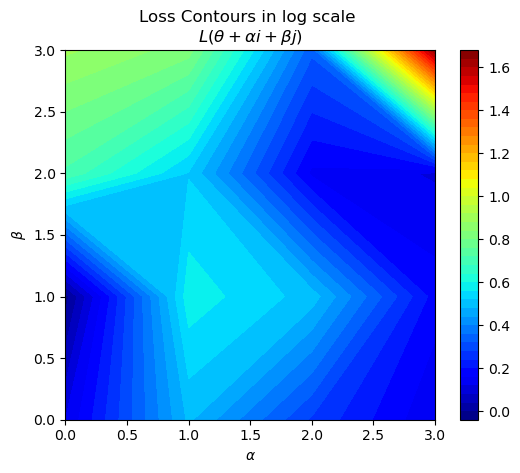

In [33]:
save_fig_name = os.path.join('loss_contours.png')
fig, ax = plt.subplots(1, 1)
plt.contourf(np.log10(avg_loss_landscape), levels=50, cmap='jet')
ax.set_title('Loss Contours in log scale \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

In [34]:
test_loss_landscapes_list = []
for i, batch in tqdm(enumerate(test_subset_dataloader), total=len(test_subset_dataloader)):
    x_train = (batch[0].to(device), batch[1].to(device))
    y_train = (batch[2].to(device))
    metric = Loss(loss_func, func.eval(), x_train, y_train) #actually x_test,y_test but named differently
    try:
        loss_data_fin = loss_landscapes.planar_interpolation(
            model_start=func.eval(), 
            model_end_one=model_eig_max.eval(),
            model_end_two=model_eig_min.eval(),
            metric=metric, steps=STEPS, deepcopy_model=True
            )
        ## TODO: ugly patch to convert array from torch.tensors to np.array
        tmp_ll = []
        for row in loss_data_fin:
            tmp_row = []
            for itm in row:
                tmp_row.append(itm.detach().cpu().numpy())
            tmp_ll.append(tmp_row)

    except Exception as e:
        print(e+'batch id: '+str(i))
        # continue
    test_loss_landscapes_list.append(np.expand_dims(np.array(tmp_ll), axis=2))

100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


In [35]:
tmp = np.concatenate(test_loss_landscapes_list, axis=2)
test_avg_loss_landscape = np.mean(tmp, axis=2)
test_std_loss_landscape = np.std(tmp, axis=2)

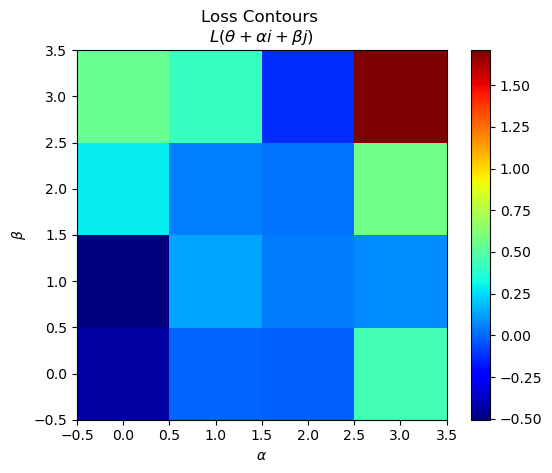

In [36]:
save_fig_name = os.path.join('loss_contours_test.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(test_avg_loss_landscape), cmap='jet', origin='lower')
ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

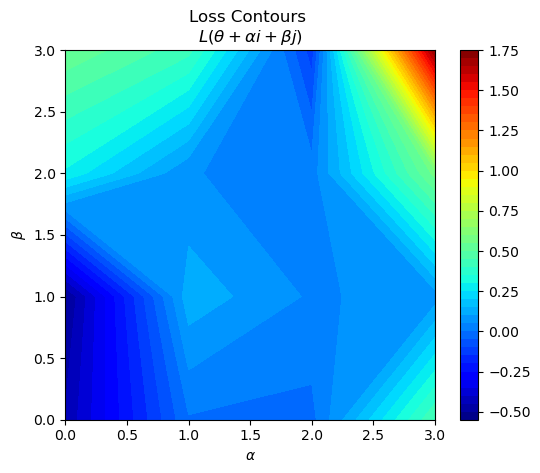

In [37]:
fig, ax = plt.subplots(1, 1)
plt.contourf(np.log10(test_avg_loss_landscape), levels=50, cmap='jet')
ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

In [38]:
x=0
y=0

for i in range(4):
        data_column = []

        for j in range(4):
            # for every other column, reverse the order in which the column is generated
            # so you can easily use in-place operations to move along dir_two

            if i % 2 == 0:
                y+= 1

                #start_point.add_(dir_two)
                print(x,y)
                #data_column.append(metric(model_start_wrapper))
            else:
                #start_point.sub_(dir_two)
                #data_column.insert(0, metric(model_start_wrapper))
                y-=1
                print(x,y)

        #data_matrix.append(data_column)
        #start_point.add_(dir_one)
        x+= 1
        print(x,y)

0 1
0 2
0 3
0 4
1 4
1 3
1 2
1 1
1 0
2 0
2 1
2 2
2 3
2 4
3 4
3 3
3 2
3 1
3 0
4 0
